<a href="https://colab.research.google.com/github/CarmenRaposo/06MAIR-Aprendizaje-No-Supervisado-Trabajo-Final/blob/master/Trabajo%20Final/Trabajo_Final-agrupado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aplicar el algoritmo KMeans al dataset iris con 3 atributos.

In [0]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets

# Problema 1:
## Datos con agrupamiento real conocido:<br>
Escogemos como base de datos de agrupamiento conocido el data set ** Iris** <br>
https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html 
<br>
Este data set recoge caracteristicas (longitud y anchura del petalo y del sepalo) y las clasifica según una de las 3 variedades de flores Iris (Setosa, Versicolour y Virginica).<br>
Consta de 150 entradas.

### Carga del dataset <br>
Cargamos el dataset en el notebook y lo guardamos en la variable Dx y Dy, para ser usado a lo largo del trabajo.<br>
Dx: contiene los 4 valores de las caracteristicas de cada entrada<br>
Dy: contiene la variedad a la que pertenece la entrada. Agrupación real de los datos.

(150, 4)


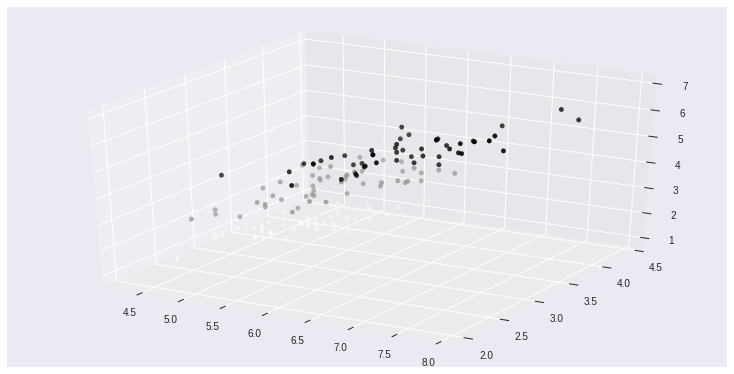

In [4]:
iris = datasets.load_iris()
Dx = iris.data[:, :3]  # we only take the first three features.
Dy = iris.target
print(iris.data.shape)

fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:,0],Dx[:,1],Dx[:,2], c=Dy)



## Procedimiento: <br>
Aplicaremos los siguientes 5 algoritmos para resolver el problema:


1.   K-Means
2.   Mixturas
3.   Aglomerativo jerárquico
4.   Espectral
5.   Densidad





### Algoritmo K-means:

Los centros iniciales elegidos aleatoriamente son:
[[6.48237556 4.02626227 3.15765851]
 [4.40734378 4.13384701 2.93605675]
 [6.51351481 2.03022485 5.51925458]]


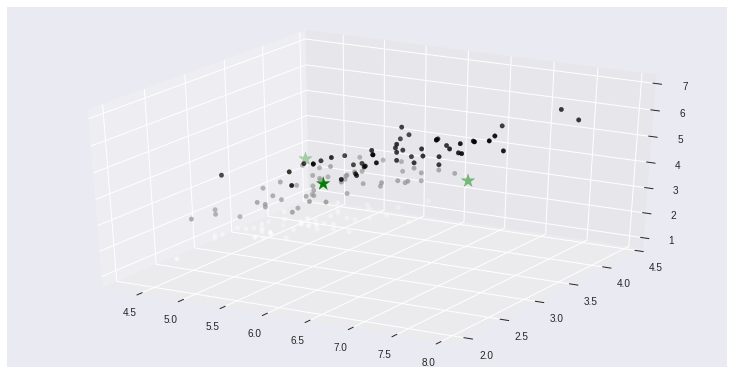

In [5]:
# Elegimos un número de clústeres a buscar
K = 3

cDx = np.zeros(K*Dx.shape[1])
cDx.shape = (K,Dx.shape[1])

def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

for d in np.arange(Dx.shape[1]):
    cDx[:,d] = random_sample_float(K, np.min(Dx[:,d]), np.max(Dx[:,d]))

print('Los centros iniciales elegidos aleatoriamente son:')
print(cDx)


fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:,0],Dx[:,1],Dx[:,2], c=Dy)
ax.scatter(cDx[:,0],cDx[:,1],cDx[:,2], marker='*', s=200, c='g')



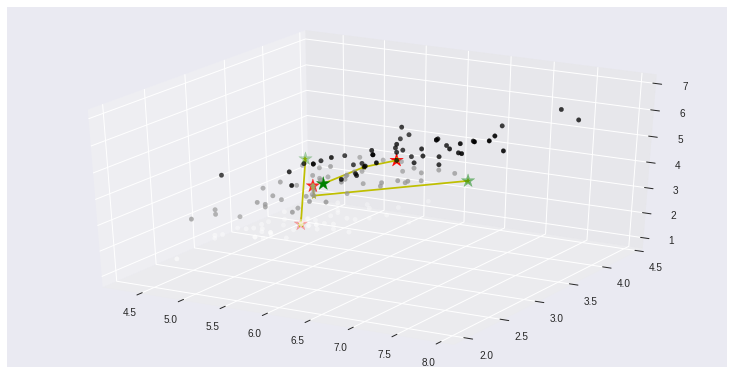

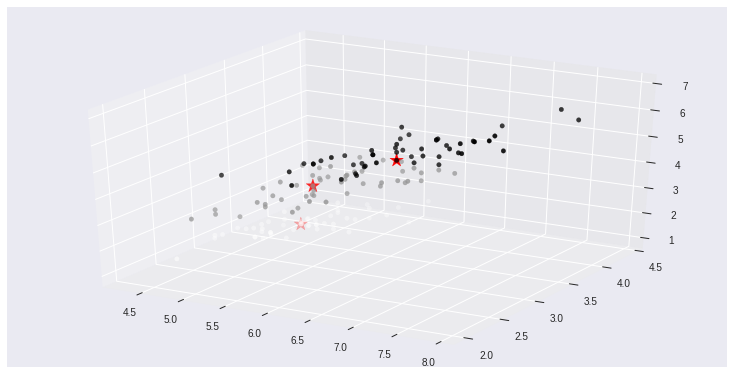

In [6]:
# Definimos la distancia euclidiana de una instancia x 
# con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):   
    return np.sqrt(np.sum(np.power(C-x,2),axis=1))

# Preparamos el vector donde guardamos la asignación de cada elemento 
# a un clúster (1,...,K)
Dyp = np.zeros(Dx.shape[0])

fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:,0],Dx[:,1],Dx[:,2], c=Dy)
ax.scatter(cDx[:,0],cDx[:,1],cDx[:,2], marker='*', s=200, c='g')

# Flag de convergencia
iterando = True


while iterando:

    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()

    # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
    for i in np.arange(Dx.shape[0]):
        pred_y = np.argmin([np.sqrt(np.sum(np.power((Dx[i,:]-cDx_ant[k,:]),2))) for k in range(K)])
        Dyp[i] = pred_y
        
    
    # Calcular los nuevos centros
    for k in range(K):
         cDx[k,:] = Dx[Dyp==k,:][np.argmin([np.sum(distancia_euclidiana_grupo(Dx[i,:],Dx[Dyp==k,:]))
                  for i in np.where(Dyp==k)[0]])]
    
    for k in np.arange(K):
        ax.plot( [cDx_ant[k,0], cDx[k,0]],[cDx_ant[k,1], cDx[k,1]],[cDx_ant[k,2], cDx[k,2]], linestyle='-', marker='*', c='y')
    
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)

ax.scatter(cDx[:,0],cDx[:,1],cDx[:,2], marker='*', s=200, c='r')

# Ver asignaciones finales
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:,0],Dx[:,1],Dx[:,2], c=Dy)
ax.scatter(cDx[:,0],cDx[:,1],cDx[:,2], marker='*', s=200, c='r')



In [7]:
 def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j]
                                          )) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)
  
def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))
  
def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales[k]
                   * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])
  
def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

mC = matriz_confusion(Dy,Dyp)

print(mC)
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC), ' (** ESTE ES EL RESULTADO A INCLUIR EN EL CAMPUS**)')
print('El valor F1 es = ', medida_f1(mC))

[[ 0 50  0]
 [34  0 16]
 [ 3  0 47]]
El valor del error cometido es =  0.1266666666666667
La pureza del agrupamiento obtenido es =  0.8733333333333334  (** ESTE ES EL RESULTADO A INCLUIR EN EL CAMPUS**)
El valor F1 es =  0.8711558674939814


Centros encontrados por...
el método programado
[[5.7 2.8 4.1]
 [5.  3.4 1.5]
 [6.5 3.  5.2]]
el método de Sci-kit Learn
[[5.006      3.428      1.462     ]
 [6.83571429 3.06428571 5.6547619 ]
 [5.84655172 2.73275862 4.3637931 ]]
Matriz de confusión:
[[50  0  0]
 [ 0  5 45]
 [ 0 37 13]]
El valor del error cometido es =  0.12
La pureza del agrupamiento obtenido es =  0.8799999999999999
El valor F1 es =  0.8792270531400966


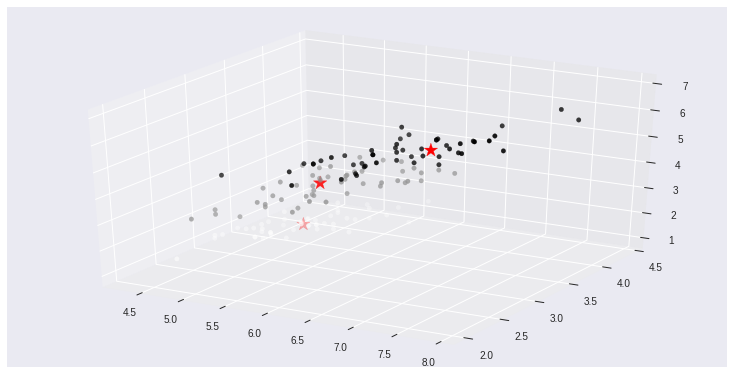

In [8]:
from sklearn.cluster import KMeans

# Se inicializa KMeans con el número de clústeres a buscar
modelo = KMeans(n_clusters=3)
# Se aprende el 
modelo = modelo.fit(Dx)
# Predicting the clusters
Dyp_sk = modelo.predict(Dx)
# Obtener los centros de los clústeres
cDx_sk = modelo.cluster_centers_

# Comparing with scikit-learn centroids
print("Centros encontrados por...")
print("el método programado")
print(cDx)
print("el método de Sci-kit Learn")
print(cDx_sk)


mC_sk = matriz_confusion(Dy,Dyp_sk)

print('Matriz de confusión:')
print(mC_sk)
print('El valor del error cometido es = ', medida_error(mC_sk))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC_sk))
print('El valor F1 es = ', medida_f1(mC_sk))

# Ver asignaciones finales
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:,0],Dx[:,1],Dx[:,2], c=Dy)
ax.scatter(cDx_sk[:,0],cDx_sk[:,1],cDx_sk[:,2], marker='*', s=200, c='r')


### Algoritmo Mixturas:

In [0]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import multivariate_normal

#%matplotlib notebook

El algoritmo EM tiene un único parámetro: el número de clústeres (K). Una vez fijado este valor, el primer paso consiste en inicializar el modelo. Se eligen unos centros iniciales de manera aleatoria, unas matrices de covarianzas fijas y unos pesos iniciales para las diferentes componentes. Sin más información, lo más normal sería asignar a todas las componentes el mismo peso.

In [0]:
######################## INICIALIZACION ########################
# Elegimos un número de clústeres a buscar
K = 3

# Asignar unas matrices de covarianzas iniciales
sigmas = []
for k in np.arange(K):
    sigmas.append( np.diag( 0.1 * np.ones( Dx.shape[1] ) ) )

# Inicialmente consideramos que todas las componentes tienen la misma probabilidad
PIs = np.ones(K)/K

In [17]:
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

# Elegir unos centros (uno para cada componente) de manera aleatoria
cDx = np.zeros(K*Dx.shape[1])
cDx.shape = (K,Dx.shape[1])

for d in np.arange(Dx.shape[1]):
    cDx[:,d] = random_sample_float(K, np.min(Dx[:,d]), np.max(Dx[:,d]))

print('Los centros iniciales elegidos aleatoriamente son:')
print(cDx)

Los centros iniciales elegidos aleatoriamente son:
[[6.64861614 4.28080496 4.61181418]
 [6.72048762 3.99047265 2.43401438]
 [6.31602083 2.38979213 6.31547471]]


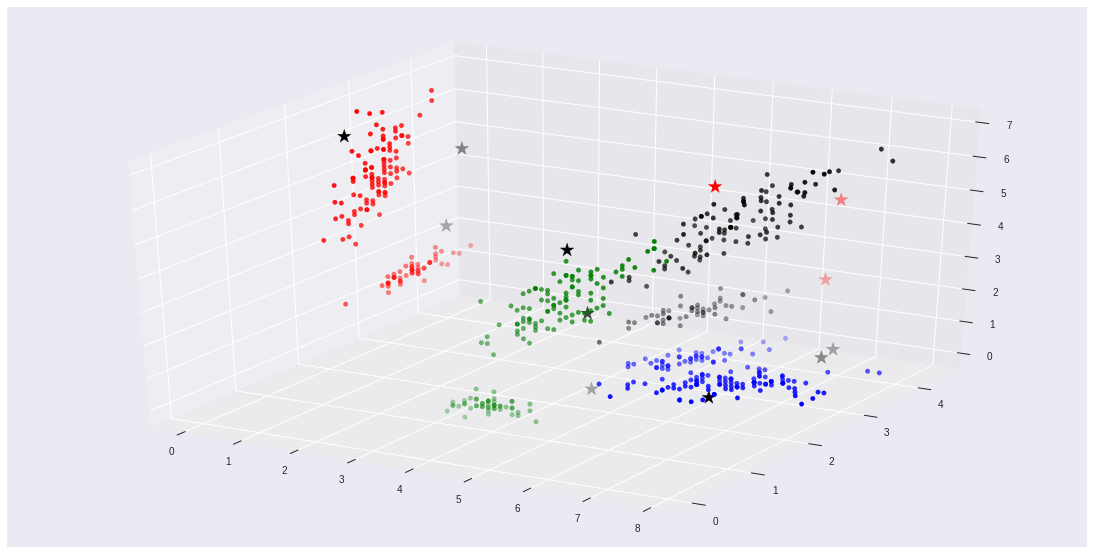

In [18]:
# Mostramos las componentes iniciales
fig = plt.figure(figsize=(15,7.5))
ax = Axes3D(fig)

color= ['r', 'g', 'b']
for k in range(Dx.shape[1]):
  Dx_copy = Dx.copy()
  cDx_copy= cDx.copy()
  Dx_copy[:,k]=0
  cDx_copy[:,k]=0
  ax.scatter(Dx_copy[:,0], Dx_copy[:,1], Dx_copy[:,2], c=color[k])
  ax.scatter(cDx_copy[:,0],cDx_copy[:,1], cDx_copy[:,2], marker='*', s=200, c='black')

ax.scatter(Dx[:,0],Dx[:,1], Dx[:,2], c='black')
ax.scatter(cDx[:,0],cDx[:,1], cDx[:,2], marker='*', s=200, c='r')

fig.show()


Una vez inicializado, el algoritmo EM ejecuta un bucle donde se repiten los pasos E y M hasta que se alcanza la convergencia. 

En el paso E se (re)calcula la probabilidad de que cada ejemplo pertenezca a cada una de las componentes (los valores $z_{ik}$). 

En el paso M se (re)calculan los parámetros del modelo: los centros de las distribuciones normales (uno por componente, $\mu_k$), las matrices de covarianzas de las normales (una por componente, $\Sigma_k$) y los coeficientes de importancia de las diferentes componentes ($\{\pi_k\}_{k=1}^K$, con $\sum_k \pi_k=1$).

El algoritmo alcanza la convergencia cuando los parámetros no cambian entre dos iteraciones consecutivas..

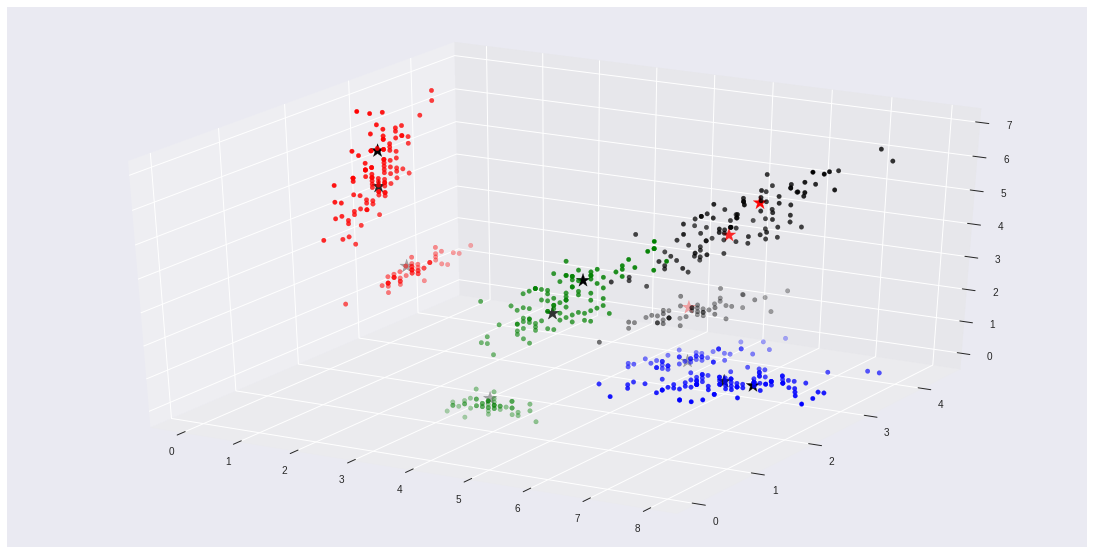

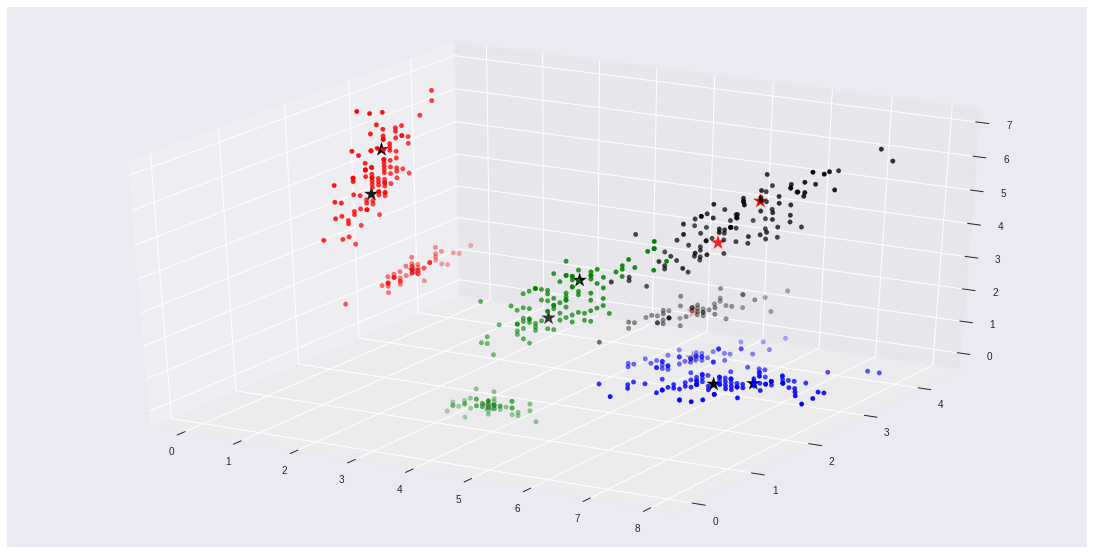

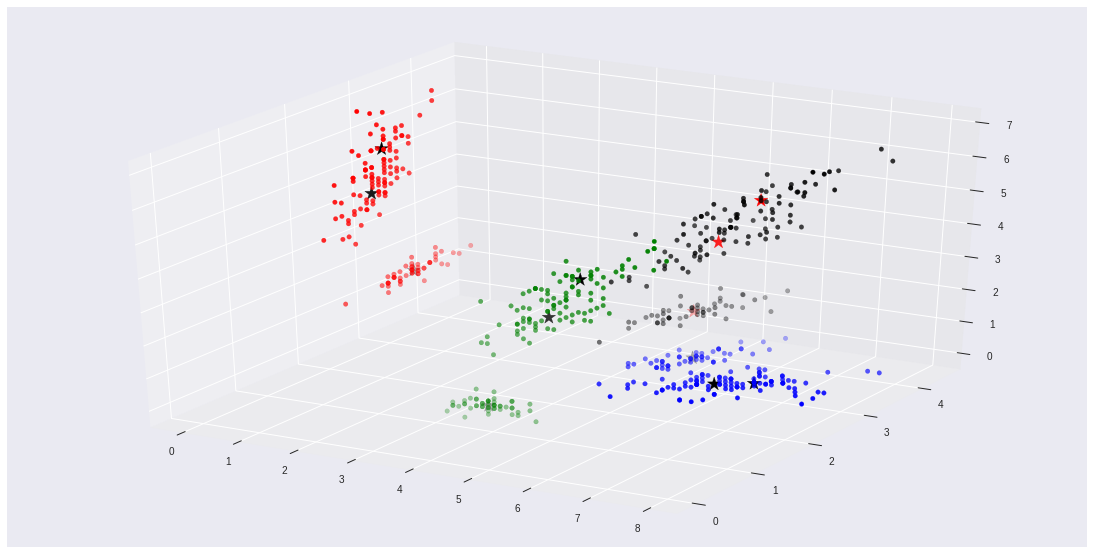

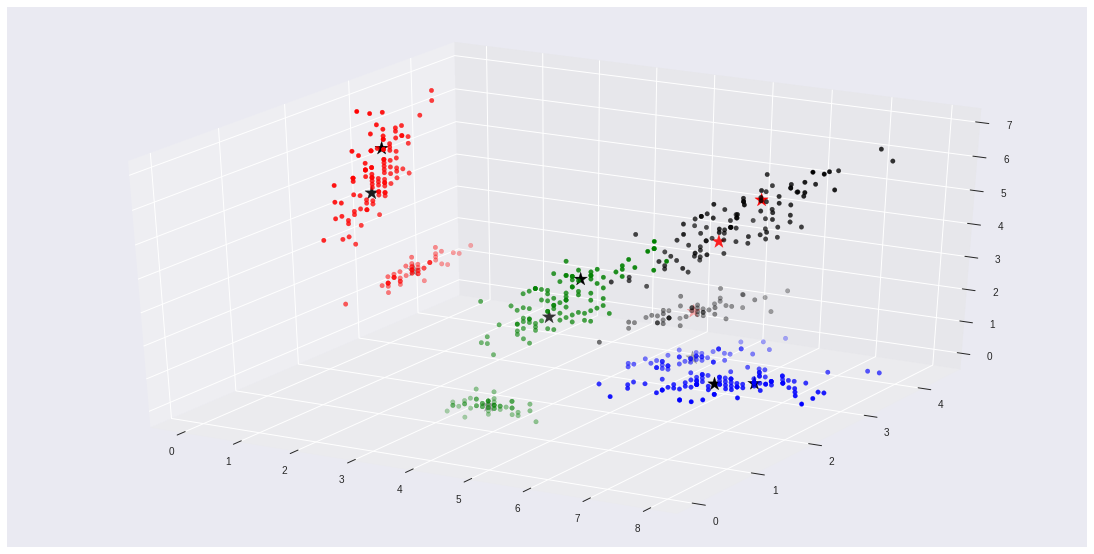

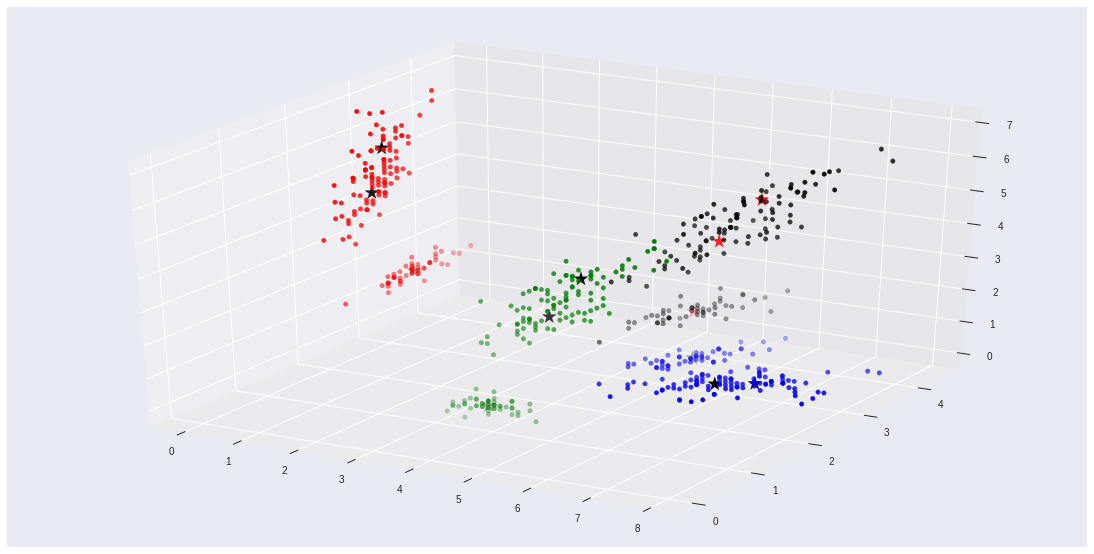

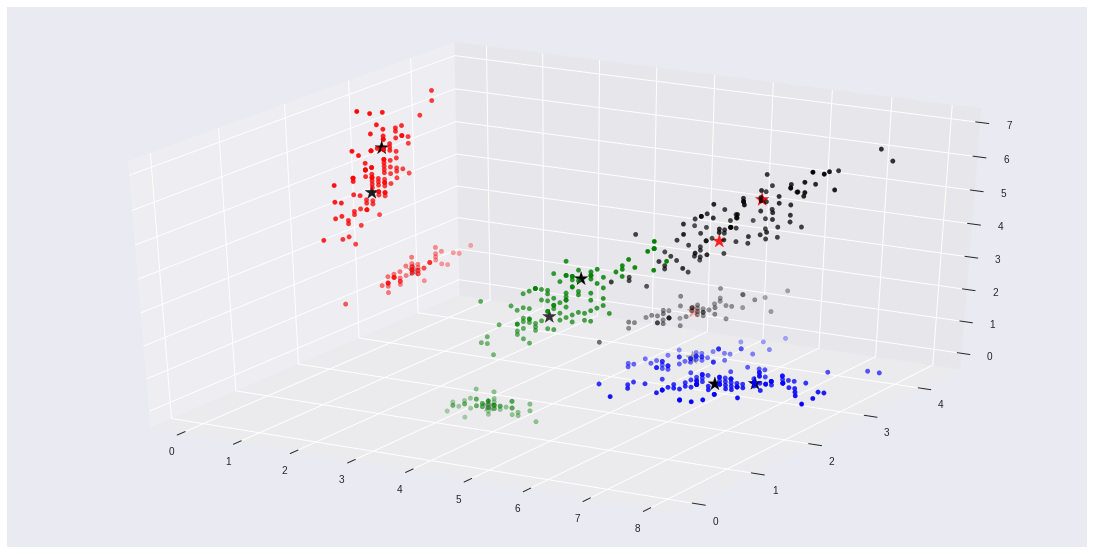

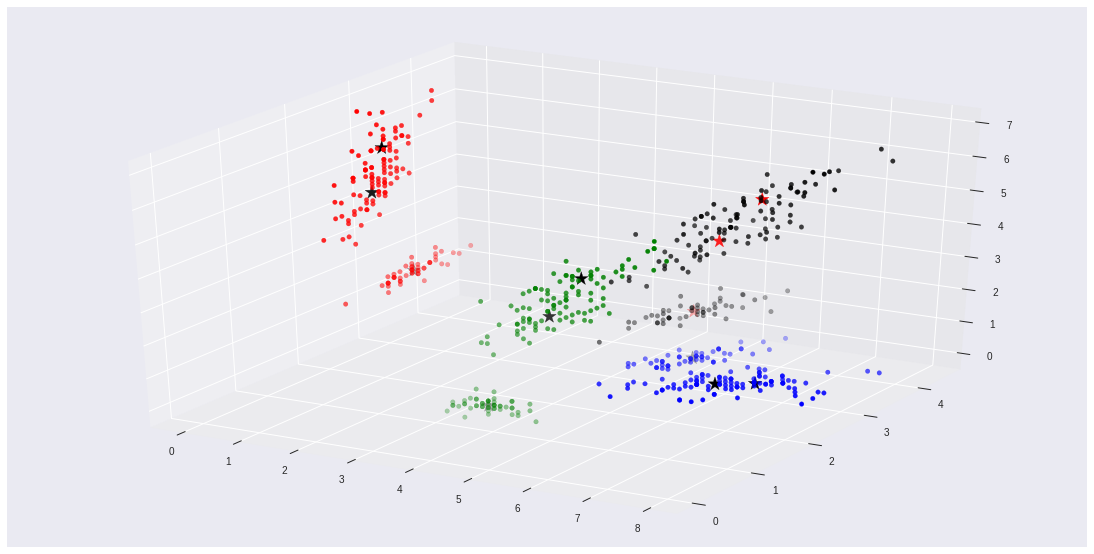

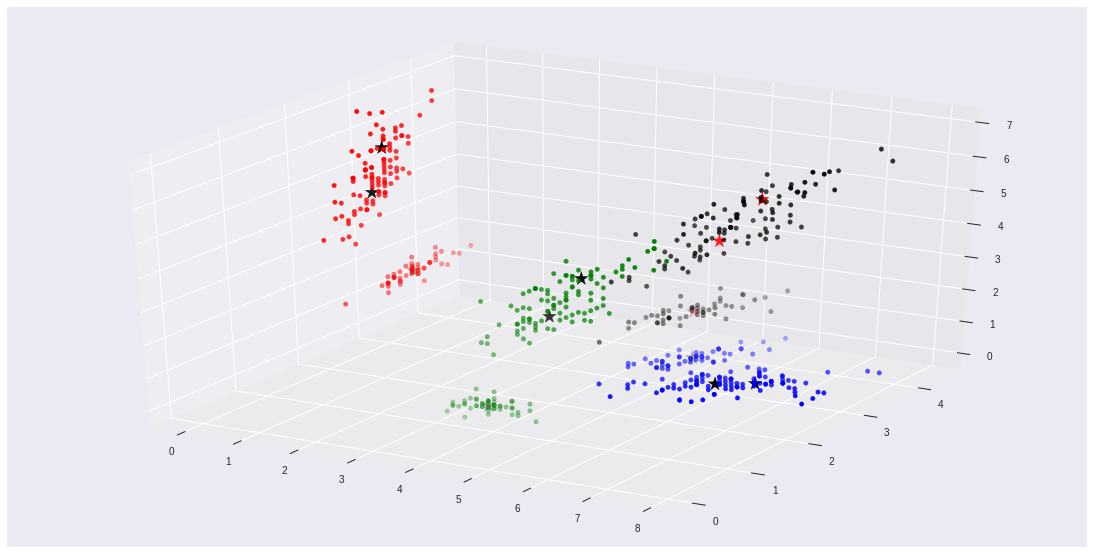

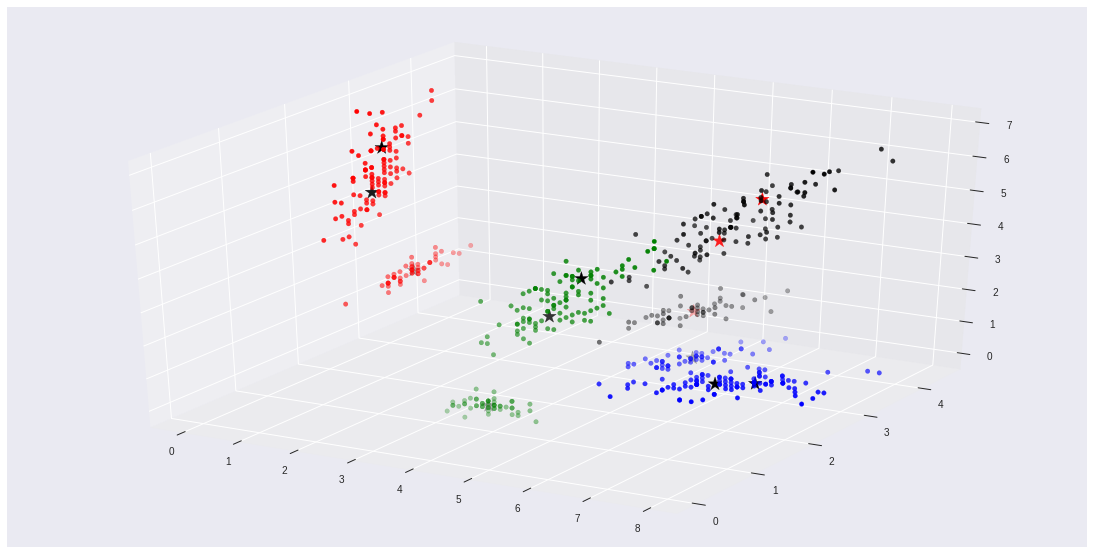

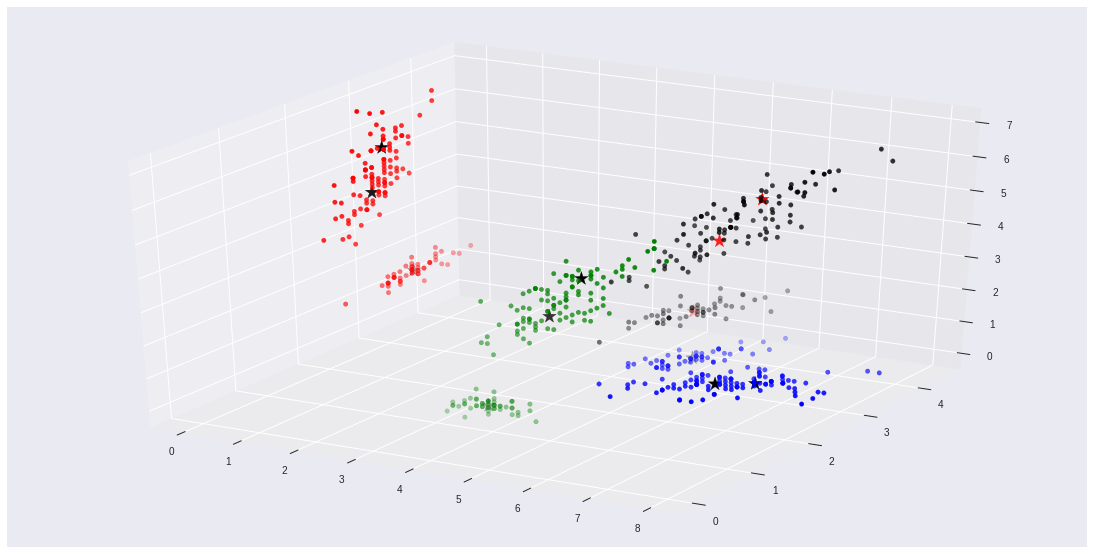

In [19]:
# Preparamos el vector donde guardamos la asignación probabilística 
# de cada elemento a un clúster (z_ik)
Dy_probs = np.zeros((Dx.shape[0], K))

# Preparamos el vector donde guardamos la asignación probabilística 
# de cada elemento a un clúster (z_ik)
Dy_probs = np.zeros((Dx.shape[0], K))

# Flag de convergencia
iterando = True
# Dibujar los plots intermedios?
dibujar = True
# Si dibujas, sólo uno de cada 'frec_dibujo'
frec_dibujo = 10

it = 0

while iterando:

    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    
    # PASO E:
    # Calcular la asignacion a las componentes (z_ik)
    for k in np.arange(K):
        Dy_probs[:,k] = PIs[k] * multivariate_normal.pdf(Dx, mean=cDx[k,:], cov=sigmas[k])
    Dy_probs = Dy_probs/np.sum(Dy_probs,axis=1)[:,None]
    
    # PASO M:
    # - a: Calcular los nuevos centros de las K componentes
    for k in range(K):
        cDx[k,:] = np.sum(Dy_probs[:,k,None]*Dx,axis=0)/np.sum(Dy_probs[:,k])

    # - b: Calcular la matriz de covarianza (sigma) de las K componentes
    for k in range(K):
        sigmas[k] = np.sum([Dy_probs[i,k]* np.dot(Dx[i,:,None]-cDx[k,:,None],
                                                  (Dx[i,:,None]-cDx[k,:,None]).transpose())
                            for i in np.arange(Dx.shape[0])], axis=0) / np.sum(Dy_probs[:,k])

    # - c: Calcular los coeficientes de importancia de las diferentes componentes
    PIs = np.sum(Dy_probs,axis=0)/Dx.shape[0]

    if dibujar and (it % frec_dibujo) == 0:
        # Dibujar el plot con el resultado actual
        
        fig = plt.figure(figsize=(15,7.5))
        ax = Axes3D(fig)
        
        color= ['r', 'g', 'b']
        for k in range(Dx.shape[1]):
          Dx_copy = Dx.copy()
          cDx_copy= cDx.copy()
          Dx_copy[:,k]=0
          cDx_copy[:,k]=0
          ax.scatter(Dx_copy[:,0], Dx_copy[:,1], Dx_copy[:,2], c=color[k])
          ax.scatter(cDx_copy[:,0],cDx_copy[:,1], cDx_copy[:,2], marker='*', s=200, c='black')

        ax.scatter(Dx[:,0],Dx[:,1], Dx[:,2], c='black')
        ax.scatter(cDx[:,0],cDx[:,1], cDx[:,2], marker='*', s=200, c='r')


    it += 1
    if np.allclose(cDx, cDx_ant):
        break

In [20]:
np.argmax(Dy_probs,axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2])

El resultado final del algoritmo es una matriz de probabilidades que asigna cada elemento a un clúster (componente) con cierta probabilidad. Si quisiésemos obtener una asignación determinista de cada caso a un único clúster, tomaríamos la componente que mayor probabilidad asigna a cada caso como su clúster:

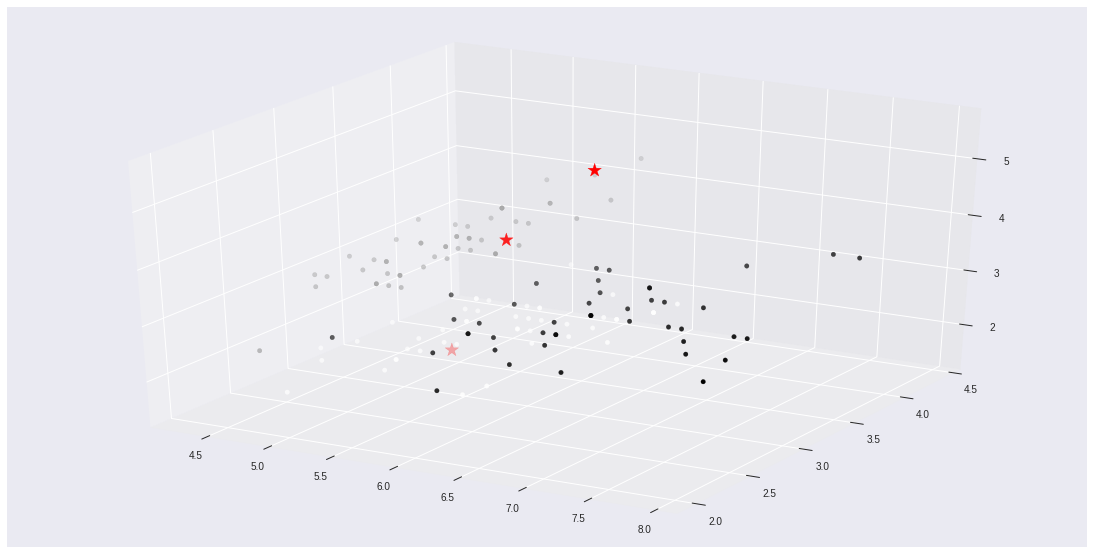

In [21]:
Dyp = np.argmax(Dy_probs,axis=1)

# Ver asignaciones finales
fig = plt.figure(figsize=(15,7.5))
ax = Axes3D(fig)

ax.scatter(Dx[:,0],Dx[:,1], Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], cDx[:,2], marker='*', s=200, c='r')

Como en anteriores ocasiones, podemos estudiar la bondad del agrupamiento ya que se conoce la realidad:

In [22]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales[k] * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

mC = matriz_confusion(Dy,Dyp)

print(mC)
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
print('El valor F1 es = ', medida_f1(mC))

[[ 0 50  0]
 [47  0  3]
 [ 8  0 42]]
El valor del error cometido es =  0.07333333333333336
La pureza del agrupamiento obtenido es =  0.9266666666666665
El valor F1 es =  0.9264828738512949


<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo EM para mixturas de Gaussianas. 

Matriz de confusión:
[[ 0 50  0  0]
 [18  0 32  0]
 [29  0  3 18]]
El valor del error cometido es =  0.26
La pureza del agrupamiento obtenido es =  0.86
El valor F1 es =  0.7836264402668283


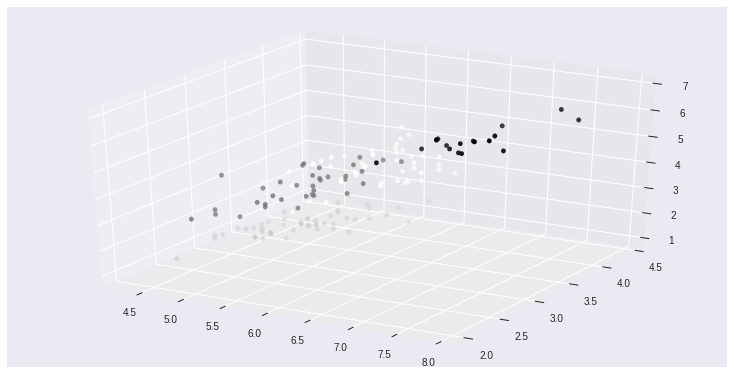

In [23]:
from sklearn.mixture import GaussianMixture

# Se inicializa el método con el número de clústeres (componentes) a buscar
modelo = GaussianMixture(n_components = 4, max_iter = 200)
# Se aprende el modelo
modelo = modelo.fit(Dx)
# Se predicen las asignaciones a clústeres
Dyp_sk = modelo.predict(Dx)

# Medimos el rendimiento del algoritmo de ScikitLearn
mC_sk = matriz_confusion(Dy,Dyp_sk)

print('Matriz de confusión:')
print(mC_sk)
print('El valor del error cometido es = ', medida_error(mC_sk))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC_sk))
print('El valor F1 es = ', medida_f1(mC_sk))

# Ver asignaciones finales
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:,0],Dx[:,1],Dx[:,2], c=Dyp_sk)


El algoritmo anterior, ejecutado a la primera, puede dar un resultado no óptimo: se está eligiendo una inicialización que encalla en un óptimo local. Si se ejecuta en varias ocaciones, eventualmente se obtendrá el resultado óptimo.

Podríamos comparar el resultado de nuestro algoritmo y el de la implementación de ScikitLearn para observar si devuelven el mismo resultado:

In [24]:
# Si comparamos el resultado de ambos algoritmos, el nuestro y el de ScikitLearn
mC_comp = matriz_confusion(Dyp,Dyp_sk)

print('Matriz de confusión:')
print(mC_comp)
print('El valor del error cometido es = ', medida_error(mC_comp))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC_comp))
print('El valor F1 es = ', medida_f1(mC_comp))

Matriz de confusión:
[[24  0 31  0]
 [ 0 50  0  0]
 [23  0  4 18]]
El valor del error cometido es =  0.30666666666666664
La pureza del agrupamiento obtenido es =  0.82
El valor F1 es =  0.7573544973544974



### Algoritmo Jerárquico aglomerativo

Usamos las funciones disponibles en las distintas librerias de Python

In [0]:
#Importamos librerias necesarias para los algoritmos aglomerativos
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster, cut_tree
# Importamos la libreria para el método dendrogram de scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster


#Con el paámetro linkage podemos controlar los criterios usados. 
#Probaremos 3 criterios: disimilitud mínima : 'single'; máxima: 'complete'; y media: 'average'

#Dx viene definido al inicio del notebook y es comun para los 3 bloques.

modelo_single = AgglomerativeClustering(linkage="single")
modelo_single = modelo_single.fit(Dx)

modelo_complete = AgglomerativeClustering(linkage="complete")
modelo_complete = modelo_complete.fit(Dx)

modelo_average = AgglomerativeClustering(linkage="average")
modelo_average = modelo_average.fit(Dx)

Dendrograma según criterio de disimilitud: mínima, máxima, media


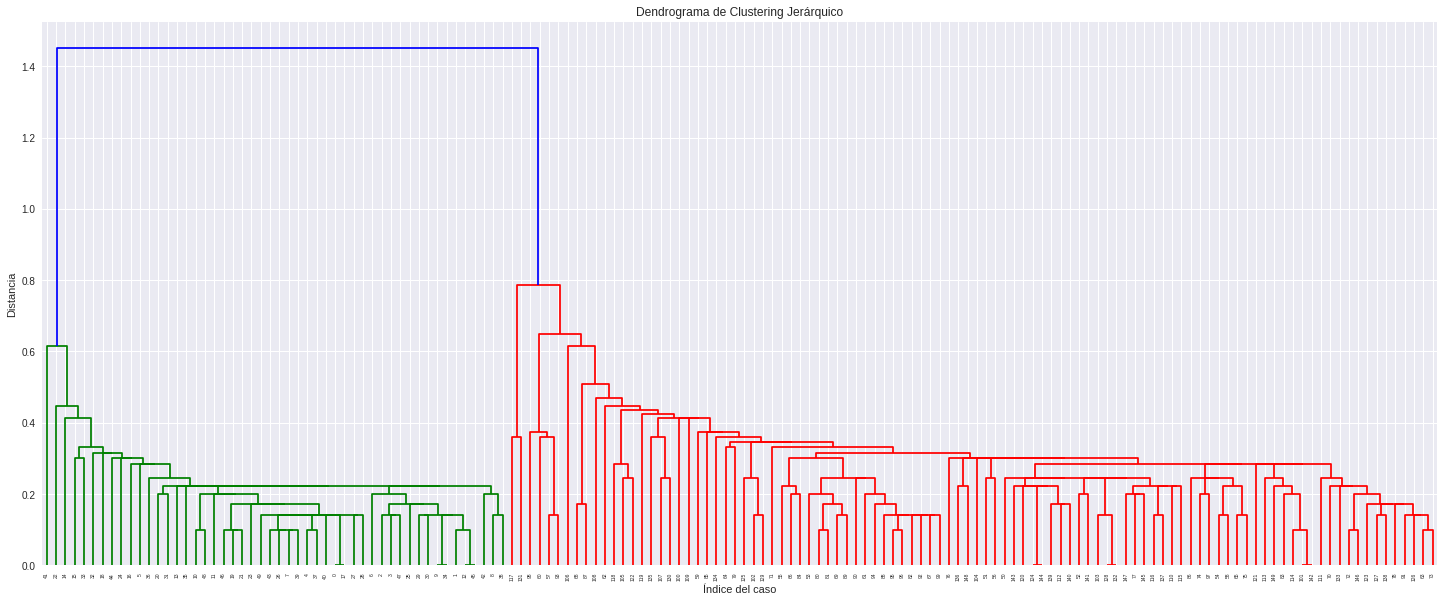

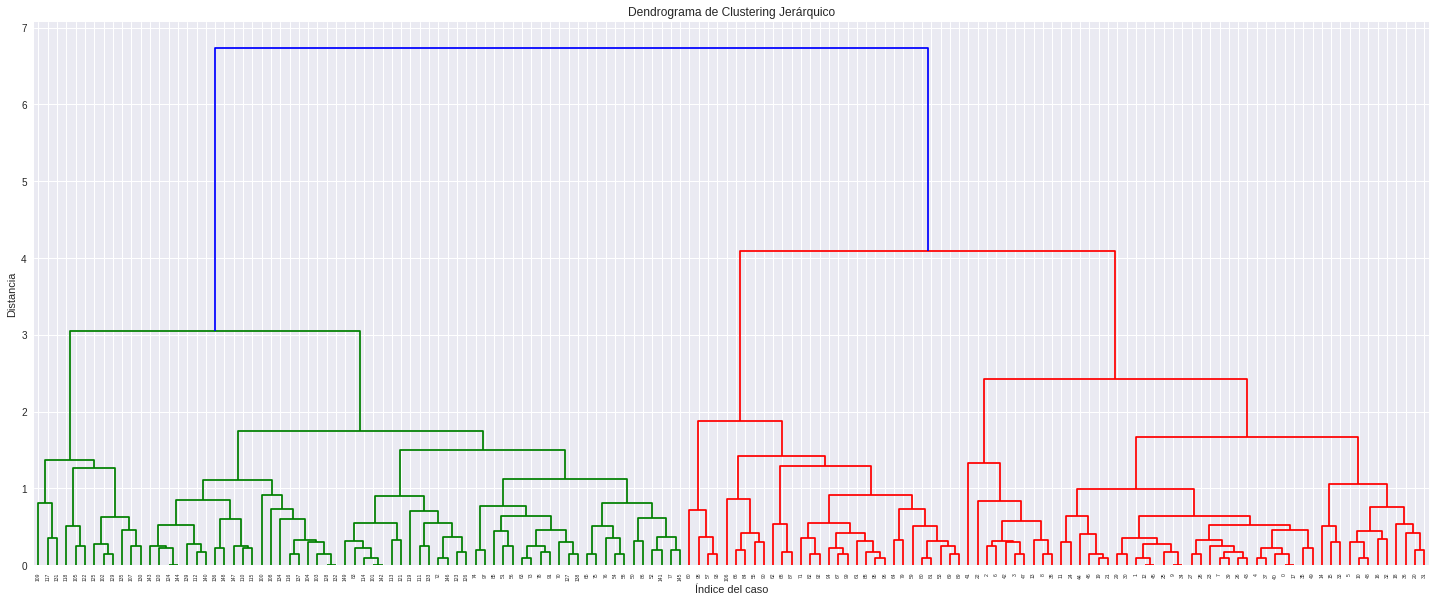

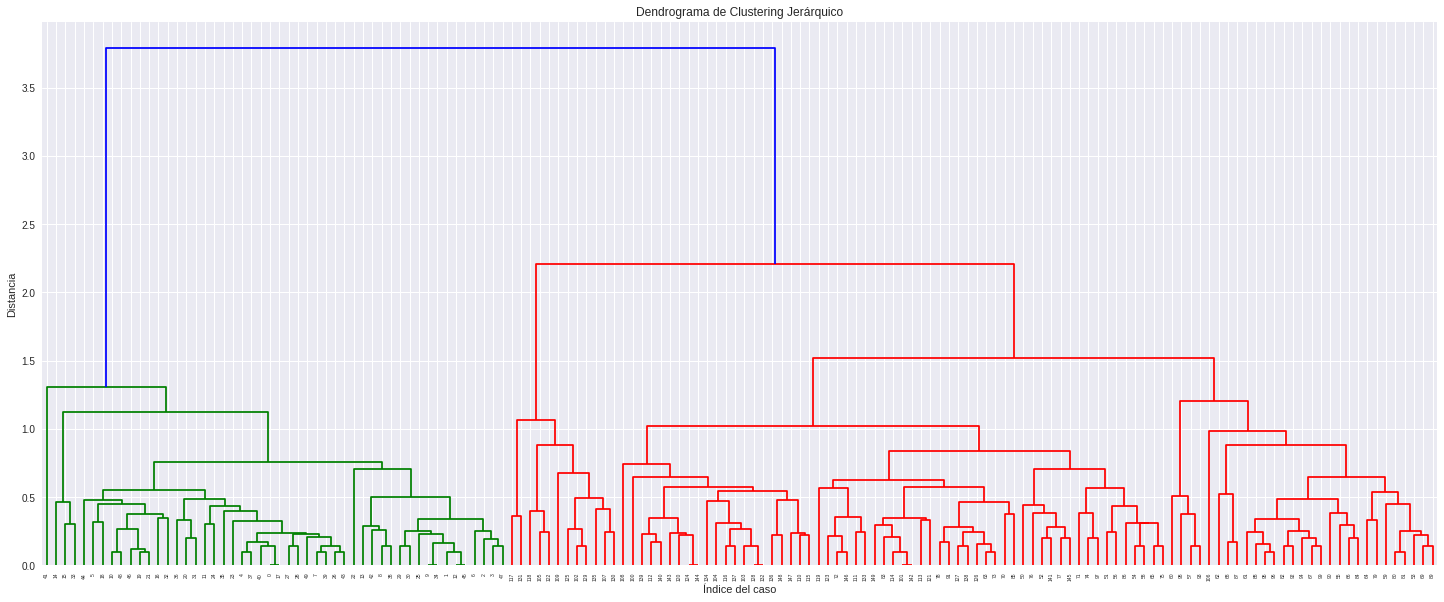

In [26]:
def matriz_enlaces(modelo):
  # Creamos la matriz de enlaces que necesita el método dendrogram de scipy
  uniones = modelo.children_
  # Las distancias y los tamaños, en esta ocasión, los asignamos de manera 
  # inocua para no alterar el resultado (no disponemos de la información completa)
  distancias = np.arange(uniones.shape[0])
  tamanyos = np.arange(2, uniones.shape[0]+2)
  mEnlaces = np.column_stack([uniones, distancias, tamanyos]).astype(float)

  return dendrogram(mEnlaces)

#función imprimir dendrograma
def plot_den(modelo):
  plt.figure(figsize=(25, 10))
  plt.title('Dendrograma de Clustering Jerárquico')
  plt.xlabel('Índice del caso')
  plt.ylabel('Distancia')
  dendrogram(modelo)
  plt.show() 
  
  
# Creamos la matriz de enlaces para cada criterio
#matriz_enlaces(modelo_single)
#matriz_enlaces(modelo_complete)
#matriz_enlaces(modelo_average)


modelo_single = linkage(Dx, 'single')   # disimilitud mínima
modelo_complete = linkage(Dx, 'complete') # disimilitud máxima
modelo_average = linkage(Dx, 'average')  # disimilitud media

#Representamos el dendrograma según cada criterio de disimilitud
print("Dendrograma según criterio de disimilitud: mínima, máxima, media")
plot_den(modelo_single)
plot_den(modelo_complete)
plot_den(modelo_average)

In [0]:
from sklearn.metrics import mutual_info_score, silhouette_score,  calinski_harabaz_score

def calcular_clusters(modelo, K):
  return cut_tree(modelo, n_clusters = K).flatten()

def evaluar_cluster(K):

    clust_single=calcular_clusters(modelo_single, K)
  
    clust_complete=calcular_clusters(modelo_complete, K)

    clust_average=calcular_clusters(modelo_average, K)

    return clust_single, clust_complete, clust_average
    
def plot_cluster(Dx, Dy, vector_clusters):
    fig, ax = plt.subplots(1,4, figsize=(20,5))
    ax[0].scatter(Dx[:,0], Dx[:,1], c=Dy)
    ax[0].set_title('Datos originales')
    plt.figure(figsize=(25, 10))
    

    ax[1].scatter(Dx[:,0], Dx[:,1], c=vector_clusters[0], cmap='rainbow')
    ax[1].set_title('Disimilitud mínima, k=%s'%K)
        

    ax[2].scatter(Dx[:,0], Dx[:,1], c=vector_clusters[1], cmap='rainbow')
    ax[2].set_title('Disimilitud máxima, k=%s'%K)
    

    ax[3].scatter(Dx[:,0], Dx[:,1], c=vector_clusters[2], cmap='rainbow')
    ax[3].set_title('Disimilitud media, k=%s'%K)
    
    plt.figure()


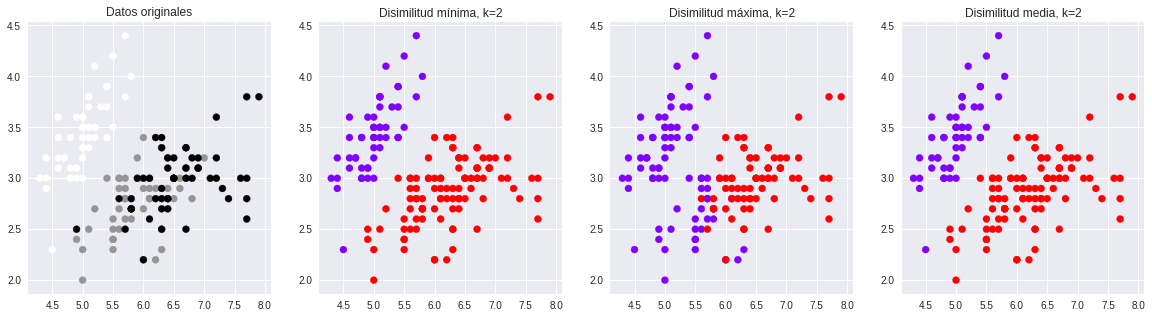

<Figure size 1800x720 with 0 Axes>

<Figure size 576x396 with 0 Axes>

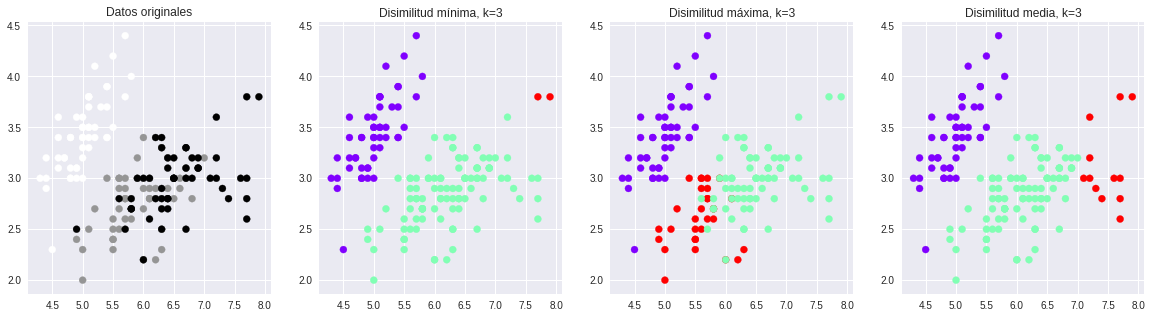

<Figure size 1800x720 with 0 Axes>

<Figure size 576x396 with 0 Axes>

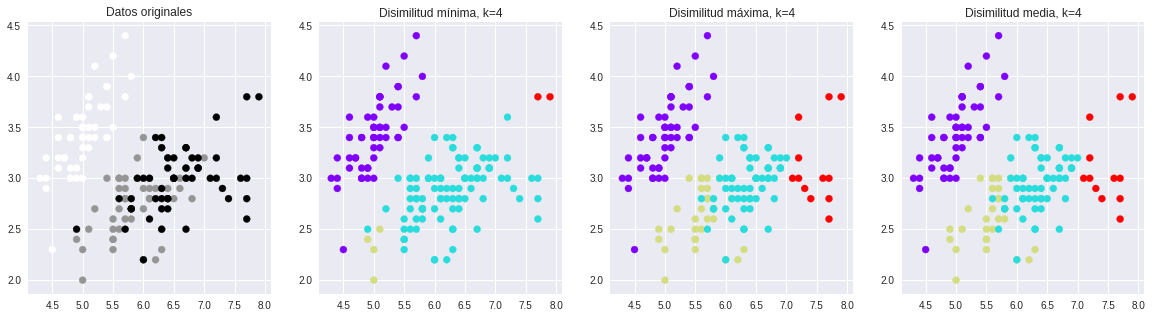

<Figure size 1800x720 with 0 Axes>

<Figure size 576x396 with 0 Axes>

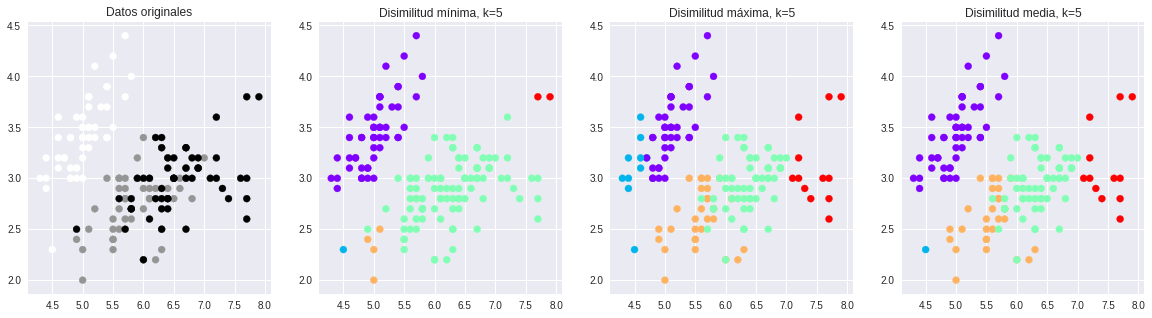

<Figure size 1800x720 with 0 Axes>

<Figure size 576x396 with 0 Axes>

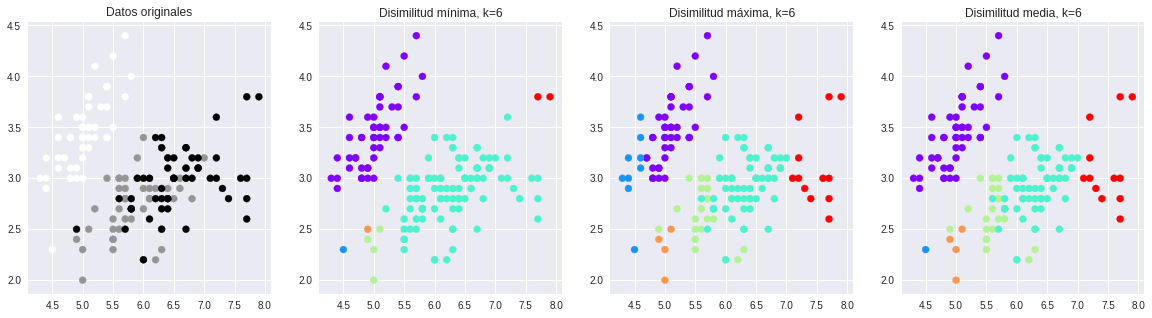

<Figure size 1800x720 with 0 Axes>

<Figure size 576x396 with 0 Axes>

In [28]:
#Evaluamos el método según diferentes valores de K y usando los 3 criterios de disimilitud: mínima, máxima, media

index_k=0
vector_clusters = {}
for K in range(2,7):
  vector_clusters[index_k]=evaluar_cluster(K)
  plot_cluster(Dx, Dy, vector_clusters[index_k])
  index_k=index_k+1

In [29]:
for i in range(len(vector_clusters)):
  print("")
  print("")
  print("Metricas evaluación:")
  print('K=%s'%(i+2))
  for y in range(len(vector_clusters[i])):
    print()
    mC = matriz_confusion(Dy,vector_clusters[i][y])
    print(mC)
    print('El valor del error cometido es = ', medida_error(mC))
    print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
    print('El valor F1 es = ', medida_f1(mC))
    print('Disimilitud mínima',silhouette_score(Dx,vector_clusters[i][y]))
    print('Disimilitud mínima',calinski_harabaz_score(Dx,vector_clusters[i][y]))



Metricas evaluación:
K=2

[[50  0]
 [ 0 50]
 [ 0 50]]
El valor del error cometido es =  0.0
La pureza del agrupamiento obtenido es =  0.6666666666666666
El valor F1 es =  0.7777777777777778
Disimilitud mínima 0.6885194944858716
Disimilitud mínima 496.72125954418374

[[50  0]
 [29 21]
 [ 1 49]]
El valor del error cometido es =  0.1466666666666666
La pureza del agrupamiento obtenido es =  0.6599999999999999
El valor F1 es =  0.6773504273504274
Disimilitud mínima 0.5021640849449348
Disimilitud mínima 257.98203652270473

[[50  0]
 [ 0 50]
 [ 0 50]]
El valor del error cometido es =  0.0
La pureza del agrupamiento obtenido es =  0.6666666666666666
El valor F1 es =  0.7777777777777778
Disimilitud mínima 0.6885194944858716
Disimilitud mínima 496.72125954418374


Metricas evaluación:
K=3

[[50  0  0]
 [ 0 50  0]
 [ 0 48  2]]
El valor del error cometido es =  0.013333333333333308
La pureza del agrupamiento obtenido es =  0.6799999999999999
El valor F1 es =  0.7747747747747749
Disimilitud mínim

# Problema 2:
## Datos con agrupamiento real desconocido:<br>
Escogemos como base de datos de agrupamiento desconocido el data set ** dataset_reducido.csv** <br>
https://github.com/jhernandezgonzalez/unsupervisedlearning/blob/master/datasets/sinteticos/dataset_reducido.csvl 
<br>


### Carga del dataset <br>
Cargamos el dataset en el notebook y lo guardamos en la variable Dx_un, para ser usado a lo largo del trabajo.<br>
Dx_un: contiene los  valores de las caracteristicas de cada entrada<br>


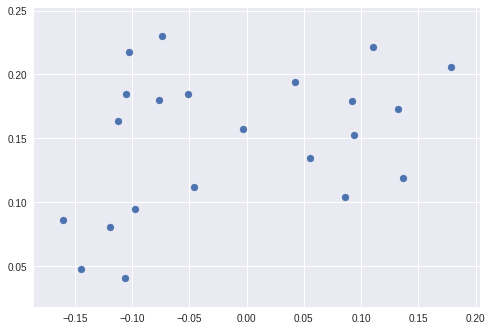

In [30]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_reducido.csv'
Dx_un = np.array(pd.read_csv(data_file_url,header=0))
Dx_un = Dx_un[ np.random.choice(np.arange(Dx_un.shape[0]), Dx_un.shape[0], replace=False) ,:]

plt.scatter(Dx_un[:,0], Dx_un[:,1])
plt.show()

## Procedimiento: <br>
Aplicaremos los siguientes 5 algoritmos para resolver el problema:


1.   K-Means
2.   Mixturas
3.   Aglomerativo jerárquico
4.   Espectral
5.   Densidad

### Aglomerativo jerárquico

Dendrograma según criterio de disimilitud: mínima, máxima, media


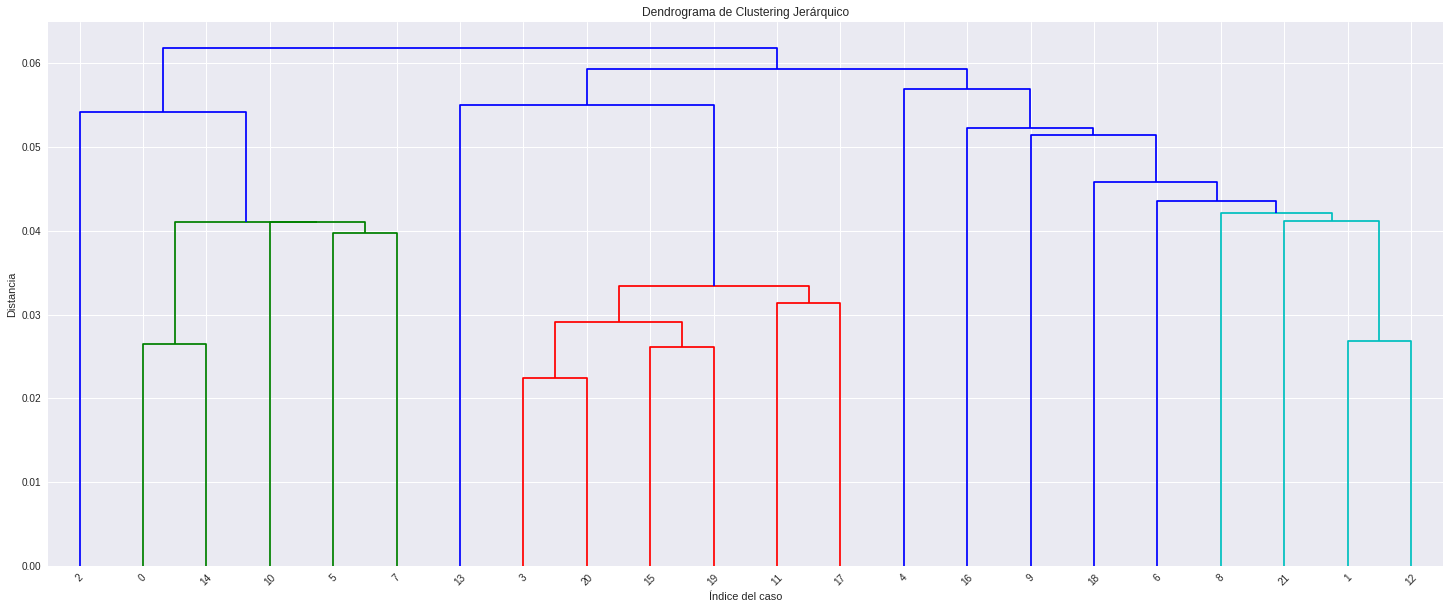

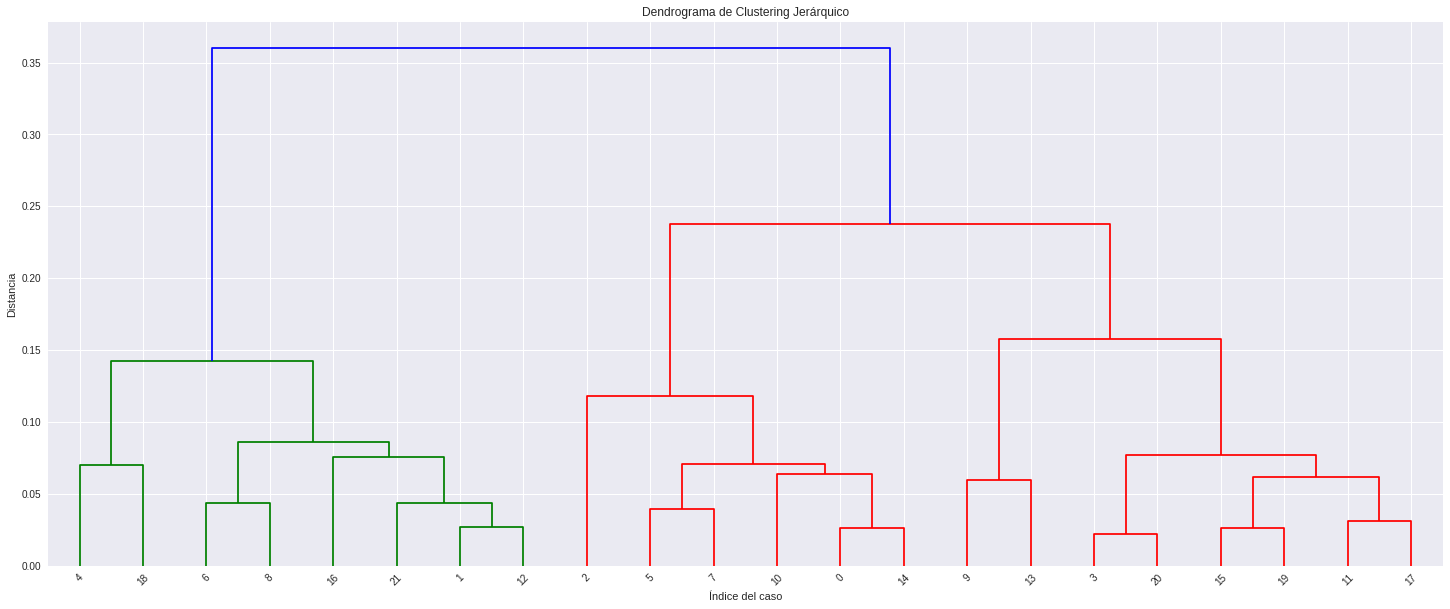

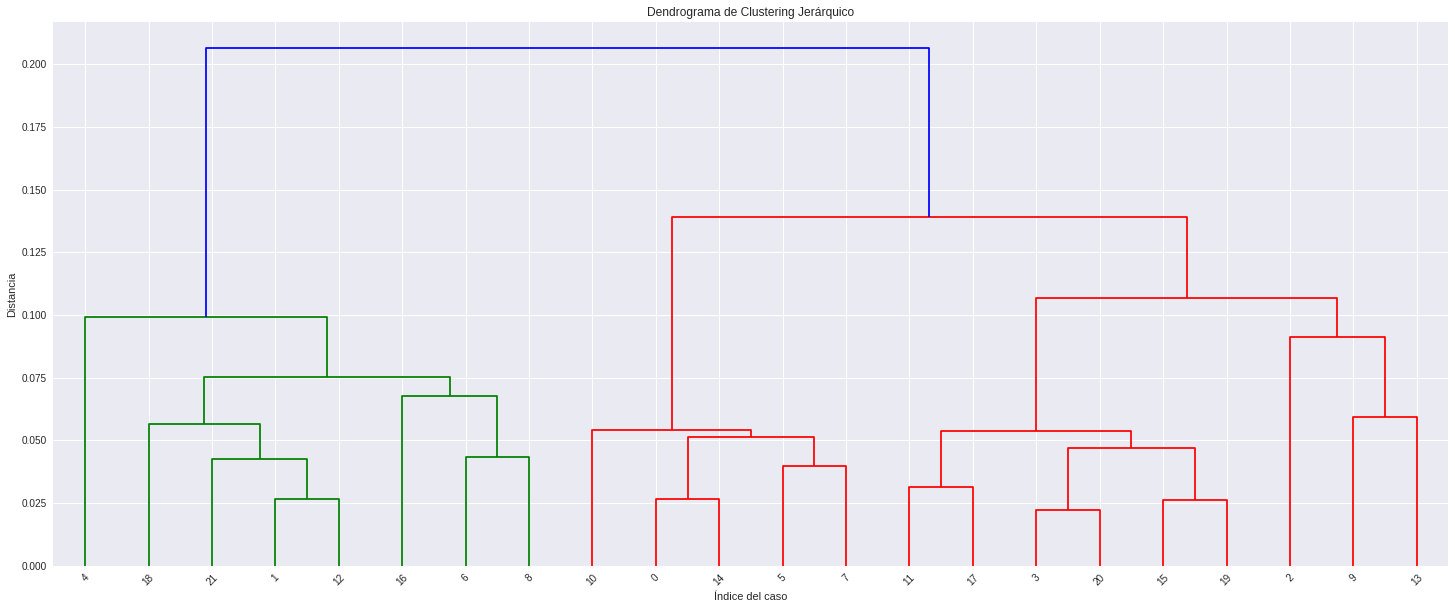

In [31]:
modelo_single_un = linkage(Dx_un, 'single')   # disimilitud mínima
modelo_complete_un = linkage(Dx_un, 'complete') # disimilitud máxima
modelo_average_un = linkage(Dx_un, 'average')  # disimilitud media

#Representamos el dendrograma según cada criterio de disimilitud
print("Dendrograma según criterio de disimilitud: mínima, máxima, media")
plot_den(modelo_single_un)
plot_den(modelo_complete_un)
plot_den(modelo_average_un)

In [0]:
def evaluar_cluster_un(K):

    clust_single=calcular_clusters(modelo_single_un, K)
  
    clust_complete=calcular_clusters(modelo_complete_un, K)

    clust_average=calcular_clusters(modelo_average_un, K)

    return clust_single, clust_complete, clust_average
    
def plot_cluster_un(Dx, vector_clusters):
    fig, ax = plt.subplots(1,3, figsize=(20,5))
    ax[0].scatter(Dx[:,0], Dx[:,1], c=vector_clusters[0], cmap='rainbow')
    ax[0].set_title('Disimilitud mínima, k=%s'%K)
        

    ax[1].scatter(Dx[:,0], Dx[:,1], c=vector_clusters[1], cmap='rainbow')
    ax[1].set_title('Disimilitud máxima, k=%s'%K)
    

    ax[2].scatter(Dx[:,0], Dx[:,1], c=vector_clusters[2], cmap='rainbow')
    ax[2].set_title('Disimilitud media, k=%s'%K)
    
    plt.figure()

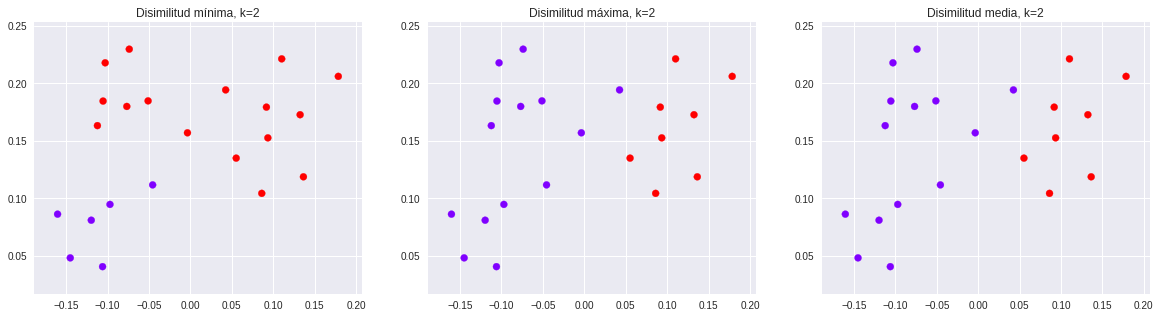

<Figure size 576x396 with 0 Axes>

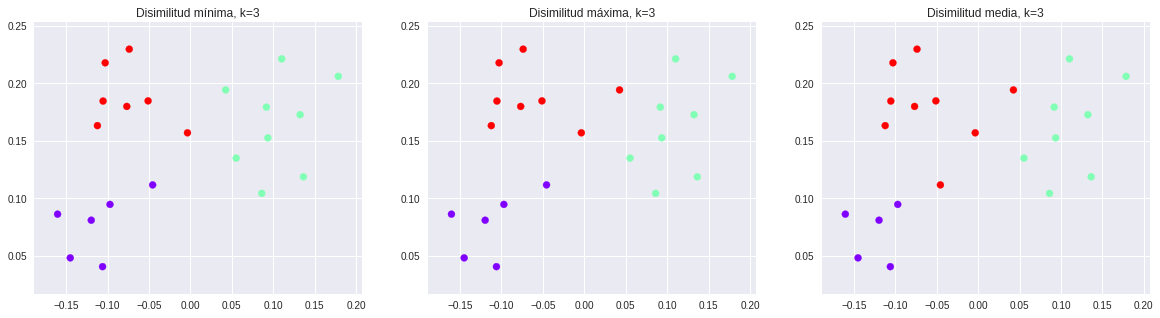

<Figure size 576x396 with 0 Axes>

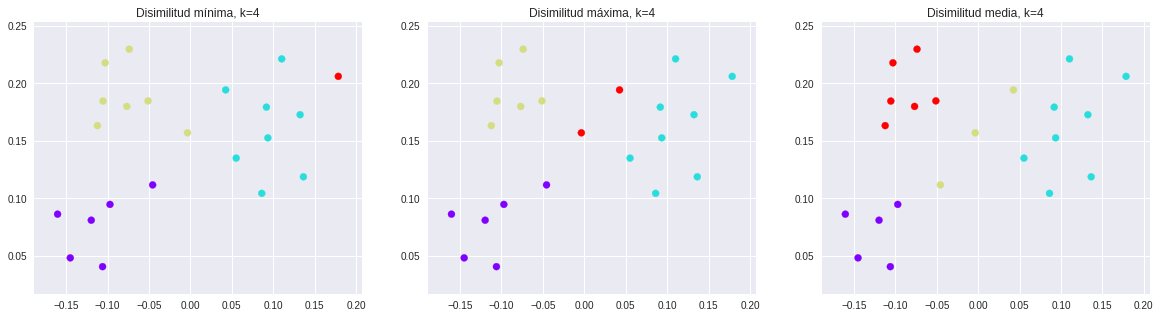

<Figure size 576x396 with 0 Axes>

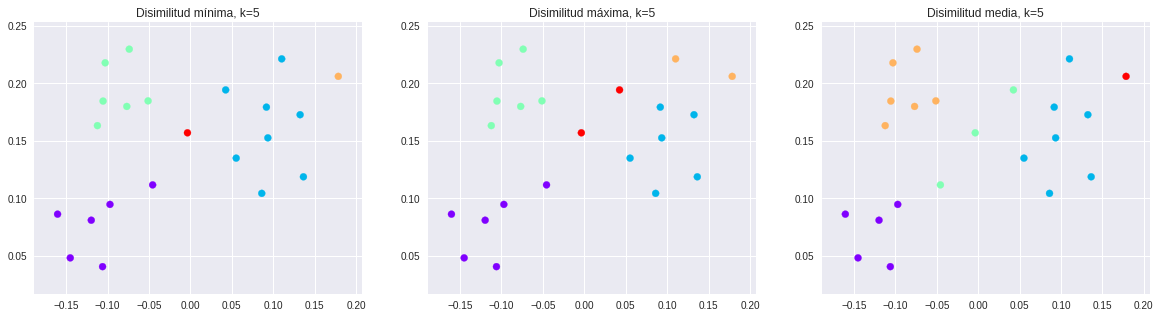

<Figure size 576x396 with 0 Axes>

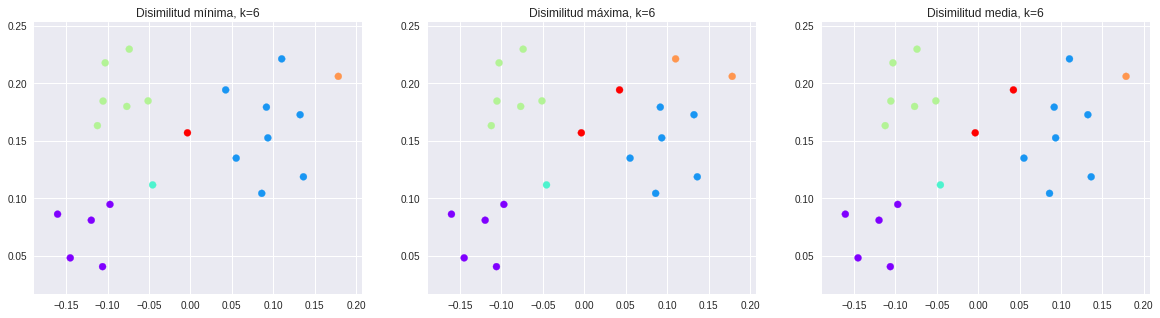

<Figure size 576x396 with 0 Axes>

In [33]:
#Evaluamos el método según diferentes valores de K y usando los 3 criterios de disimilitud: mínima, máxima, media

index_k=0
vector_clusters = {}
for K in range(2,7):
  vector_clusters[index_k]=evaluar_cluster_un(K)
  plot_cluster_un(Dx_un, vector_clusters[index_k])
  index_k=index_k+1

In [34]:
for i in range(len(vector_clusters)):
  print("")
  print("")
  print("Metricas evaluación:")
  print('K=%s'%(i+2))
  for y in range(len(vector_clusters[i])):
    print()
    print('Disimilitud mínima',silhouette_score(Dx_un,vector_clusters[i][y]))
    print('Disimilitud mínima',calinski_harabaz_score(Dx_un,vector_clusters[i][y]))



Metricas evaluación:
K=2

Disimilitud mínima 0.34763849974383726
Disimilitud mínima 13.881457561060367

Disimilitud mínima 0.5115302788587264
Disimilitud mínima 34.525933716636

Disimilitud mínima 0.5115302788587264
Disimilitud mínima 34.525933716636


Metricas evaluación:
K=3

Disimilitud mínima 0.5214152726868524
Disimilitud mínima 45.874492081681694

Disimilitud mínima 0.4756044359709163
Disimilitud mínima 39.25060541095616

Disimilitud mínima 0.48286680036848223
Disimilitud mínima 40.32749773765812


Metricas evaluación:
K=4

Disimilitud mínima 0.38328461641052347
Disimilitud mínima 35.63780823438172

Disimilitud mínima 0.396912589465728
Disimilitud mínima 37.73625335635972

Disimilitud mínima 0.4408872869802952
Disimilitud mínima 39.06472472659191


Metricas evaluación:
K=5

Disimilitud mínima 0.27197236115412593
Disimilitud mínima 30.970889148074132

Disimilitud mínima 0.3845488974016339
Disimilitud mínima 37.03773165513482

Disimilitud mínima 0.36500377275267154
Disimilitud mí